<a href="https://colab.research.google.com/github/srivatsan1991/ML_Exercises/blob/master/cifar10_two_layer_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Cifar10 classification with a two layer neural net and softmax loss

In this notebook, we implement (from scratch, i.e., only using numpy), a simple 2-layer neural net model with ReLU activation and softmax loss function. We train the model using stochastic gradient descent, and then perform hyperparameter tuning. We see that the best two layer neural net model performs with about 48% accuracy on CIFAR-10.

In [3]:
from tensorflow.keras.datasets.cifar10 import load_data
import random
import numpy as np
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules; see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [4]:
def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

# **Two Layer Net:**
We implement a two layer neural network which has input dimension $D$, hidden dimension $H$ and performs classification over $C$ classes. We train with softmax loss + L2 regularization on weight matrices. Thus schematically, we have

`input - fully connected layer - ReLU - fully connected layer - softmax`.



In [5]:
class TwoLayerNet(object):
    """
    input - fully connected layer - ReLU - fully connected layer - softmax

    The outputs of the second fully-connected layer are the scores for each class.
    """

    def __init__(self, input_size, hidden_size, output_size, std=1e-4):
        """
        Weights are initialized to small random values and biases are initialized to zero.
        Weights and biases are stored in the variable self.params, which is a dictionary with the following keys:
        W1 (shape:(D,H), first layer weights), b1 (shape:(H,), first layer biases), 
        W2 (shape:(H,C), second layer weights), b2 (shape:(C,), second layer biases), 
        """
        self.params = {}
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def loss(self, X, y=None, reg=0.0):
        """
        computes loss and gradient of 2 layer NN, in a fully vectorized manner.

        Inputs:
        - X: Input data of shape (N, D). Each X[i] is a training sample.
        - y: Vector of training labels. y[i] is the label for X[i], and each y[i] is
          an integer in the range 0 <= y[i] < C. This parameter is optional; if it
          is not passed then we only return scores, and if it is passed then we
          instead return the loss and gradients.
        - reg: Regularization strength.

        Returns:
        If y is None, return a matrix scores of shape (N, C) where scores[i, c] is
        the score for class c on input X[i].

        If y is not None, instead return a tuple of:
        - loss: Loss (data loss and regularization loss) for this batch of training
          samples.
        - grads: Dictionary mapping parameter names to gradients of those parameters
          with respect to the loss function; has the same keys as self.params.
        """
        # Unpack variables from the params dictionary
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        N, D = X.shape

        # Compute the forward pass

        #############################################################################
        # Compute class scores for the input. #
        # Store the result in the scores variable, which should be an array of      #
        # shape (N, C).                                                             #
        #############################################################################
        firstlayer = np.maximum(np.dot(X, W1) + b1, 0)
        scores = np.dot(firstlayer, W2) + b2
        flmask = np.copy(firstlayer)
        flmask[flmask > 1e-8] = 1

        # If the targets are not given then jump out, we're done
        if y is None:
            return scores

        # Compute the loss
        
        #############################################################################
        # Compute loss and grad, using softmax classifier loss and L2 reg           #
        #############################################################################

        maxscores = np.max(scores, axis=1).reshape(N, 1)
        scores = np.subtract(scores, maxscores)
        
        correctscoresum = np.sum(np.array([scores[i, y[i]] for i in range(N)]))
        
        Z = np.sum(np.exp(scores), axis=1)
        
        loss = (np.sum(np.log(np.sum(np.exp(scores), axis=1))) - correctscoresum)/N
        loss += reg * np.sum(W1 * W1)
        loss += reg * np.sum(W2 * W2)
        
        # Backward pass: compute gradients
        grads = {}
    
        # first compute gradient of loss wrt scores
        gradscores = np.exp(scores)/(Z.reshape(N,1))
        for I in range(N):
            gradscores[I, y[I]] -= 1
        gradscores /= N

        #now compute gradient of scores[I,i] wrt x=(b2,W2,b1,W1) 
        #and then multiply with gradscores to get gradient of loss wrt x
        
        grads['b2'] = np.sum(gradscores, axis = 0)
        grads['W2'] = np.dot(firstlayer.T, gradscores) + 2 * reg * W2
        grads['b1'] = np.sum(np.dot(gradscores, W2.T) * flmask, axis = 0)
        grads['W1'] = np.dot(X.T,  np.dot(gradscores, W2.T) * flmask) + 2 * reg * W1
        
        return loss, grads

    def train(self, X, y, X_val, y_val,
              learning_rate=1e-3, learning_rate_decay=0.95,
              reg=5e-6, num_iters=100,
              batch_size=200, verbose=False):
        """
        Train this neural network using stochastic gradient descent.

        Inputs:
        - X: A numpy array of shape (N, D) giving training data.
        - y: A numpy array f shape (N,) giving training labels; y[i] = c means that
          X[i] has label c, where 0 <= c < C.
        - X_val: A numpy array of shape (N_val, D) giving validation data.
        - y_val: A numpy array of shape (N_val,) giving validation labels.
        - learning_rate: Scalar giving learning rate for optimization.
        - learning_rate_decay: Scalar giving factor used to decay the learning rate
          after each epoch.
        - reg: Scalar giving regularization strength.
        - num_iters: Number of steps to take when optimizing.
        - batch_size: Number of training examples to use per step.
        - verbose: boolean; if true print progress during optimization.
        """
        num_train = X.shape[0]
        iterations_per_epoch = max(num_train / batch_size, 1)

        # Use SGD to optimize the parameters in self.model
        loss_history = []
        train_acc_history = []
        val_acc_history = []

        for it in range(num_iters):
            X_batch = None
            y_batch = None

            #########################################################################
            # we create a random minibatch of training data and labels, storing     #
            # them in X_batch and y_batch respectively.                             #
            #########################################################################
            batch_ind = np.random.choice(num_train, batch_size)
            X_batch = X[batch_ind, :]
            y_batch = y[batch_ind]
            
            # Compute loss and gradients using the current minibatch
            loss, grads = self.loss(X_batch, y=y_batch, reg=reg)
            loss_history.append(loss)

            #########################################################################
            # we use the gradients in the grads dictionary to update the            #
            # parameters of the network (stored in the dictionary self.params)      #
            # using stochastic gradient descent. You'll need to use the gradients   #
            # stored in the grads dictionary defined above.                         #
            #########################################################################

            for param_name  in self.params:
                self.params[param_name] -= learning_rate * grads[param_name]
            
            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

            # Every epoch, check train and val accuracy and decay learning rate.
            if it % iterations_per_epoch == 0:
                # Check accuracy
                train_acc = (self.predict(X_batch) == y_batch).mean()
                val_acc = (self.predict(X_val) == y_val).mean()
                train_acc_history.append(train_acc)
                val_acc_history.append(val_acc)

                # Decay learning rate
                learning_rate *= learning_rate_decay

        return {
          'loss_history': loss_history,
          'train_acc_history': train_acc_history,
          'val_acc_history': val_acc_history,
        }

    def predict(self, X):
        """
        Use the trained weights of this two-layer network to predict labels for
        data points. For each data point we predict scores for each of the C
        classes, and assign each data point to the class with the highest score.

        Inputs:
        - X: A numpy array of shape (N, D) giving N D-dimensional data points to
          classify.

        Returns:
        - y_pred: A numpy array of shape (N,) giving predicted labels for each of
          the elements of X. For all i, y_pred[i] = c means that X[i] is predicted
          to have class c, where 0 <= c < C.
        """
        y_pred = np.argmax(np.dot(np.maximum(np.dot(X, self.params['W1']) + self.params['b1'], 0), self.params['W2']) + self.params['b2'], axis = 1)

        return y_pred

## Load data:

In [11]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    (X_train, y_train), (X_test, y_test) = load_data()
    X_train = X_train.astype('float64')
    X_test = X_test.astype('float64')
    y_train = y_train.reshape(-1)
    y_test = y_test.reshape(-1)

    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape data to rows
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


## SGD:

In [12]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=1000, batch_size=200,
            learning_rate=1e-4, learning_rate_decay=0.95,
            reg=0.25, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)

iteration 0 / 1000: loss 2.302994
iteration 100 / 1000: loss 2.302606
iteration 200 / 1000: loss 2.298255
iteration 300 / 1000: loss 2.264974
iteration 400 / 1000: loss 2.220240
iteration 500 / 1000: loss 2.128625
iteration 600 / 1000: loss 2.091432
iteration 700 / 1000: loss 2.043040
iteration 800 / 1000: loss 2.065815
iteration 900 / 1000: loss 1.934320
Validation accuracy:  0.28


By running SGD with some generic choice of parameters, we have achieved 28% accuracy. We now visualize what is happening:

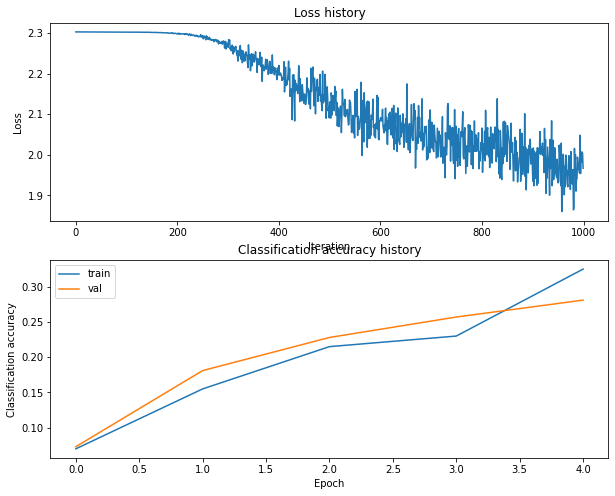

In [13]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()
plt.show()

# Hyperparameter tuning and cross-validation:

Best validation accuracy ~ 50%

In [ ]:
best_net = None # store the best model into this 
best_acc = 0

In [35]:
#################################################################################
# we tune hyperparameters using the validation set. Store your best trained     #
# model in best_net.                                                            #
#################################################################################
reg_arr = np.array([ 0.203,0.205, 0.207])
learning_rate_arr = np.array([1.75e-3, 1.8e-3, 1.85e-3])

#for cur_reg in reg_arr:
#    for cur_lr in learning_rate_arr:
for trial in range(20):         
        cur_reg = np.random.uniform(0.205,0.208)
        cur_lr  = np.random.uniform(.0015,0.0017)
        cur_net = TwoLayerNet(input_size, hidden_size, num_classes)
        
        # Train the network
        stats = cur_net.train(X_train, y_train, X_val, y_val,
            num_iters=1400, batch_size=200,
            learning_rate=cur_lr, learning_rate_decay=0.95,
            reg=cur_reg, verbose=False)

        # Predict on the validation set
        cur_acc = (cur_net.predict(X_val) == y_val).mean()
        #print('Validation accuracy: ', val_acc)
        print("reg = ",cur_reg, ", learning rate = ", cur_lr, ", validation accuracy = ", cur_acc, sep=' ', end='.\n')

        if cur_acc > best_acc:
            best_acc = cur_acc
            best_net = cur_net



reg =  0.20730977184595417 , learning rate =  0.0016888801375983238 , validation accuracy =  0.476.
reg =  0.20770490537238653 , learning rate =  0.0016009697107501474 , validation accuracy =  0.496.
reg =  0.20781555138502325 , learning rate =  0.0015537667633472867 , validation accuracy =  0.472.
reg =  0.20538859243238508 , learning rate =  0.0015545882229201042 , validation accuracy =  0.489.
reg =  0.20554498369854318 , learning rate =  0.0016309496507142926 , validation accuracy =  0.479.
reg =  0.20711922665183194 , learning rate =  0.0016208642682848235 , validation accuracy =  0.484.
reg =  0.2056585742173319 , learning rate =  0.0015389459042731435 , validation accuracy =  0.489.
reg =  0.20673486695049903 , learning rate =  0.0016255200935680393 , validation accuracy =  0.492.
reg =  0.2070921015481313 , learning rate =  0.0016014052150187402 , validation accuracy =  0.469.
reg =  0.2059721267385958 , learning rate =  0.0016461532652164868 , validation accuracy =  0.489.
reg

In [36]:
# Print your validation accuracy: this should be above 48%
val_acc = (best_net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)

Validation accuracy:  0.504


# Run on the test set:  Accuracy ~ 49%


In [37]:
# Print your test accuracy: this should be above 48%
test_acc = (best_net.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.489


In [38]:
train_acc = (best_net.predict(X_train) == y_train).mean()
print('Train accuracy: ', train_acc)

Train accuracy:  0.5128979591836734
